In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pygam import LinearGAM, s
import numpy as np
from scipy import stats
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Data Overview

In [3]:
yfinance_data = pd.read_csv('yfinance_data.csv')
yfinance_data['date'] = pd.to_datetime(yfinance_data['date'])
btc_usd_data = yfinance_data.loc[yfinance_data['currency']=='BTC-USD']
btc_usd_data.reset_index(inplace=True)
btc_usd_data

,index,currency,date,Close,High,Low,Open,Volume
0,5206,BTC-USD,2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800
1,5207,BTC-USD,2015-01-06,286.188995,287.553009,272.696014,274.610992,23245700
2,5208,BTC-USD,2015-01-07,294.337006,298.753998,283.079010,286.076996,24866800
3,5209,BTC-USD,2015-01-08,283.348999,294.135010,282.174988,294.135010,19982500
4,5210,BTC-USD,2015-01-09,290.407990,291.114014,280.532990,282.382996,18718600
...,...,...,...,...,...,...,...,...
3640,8846,BTC-USD,2024-12-23,94686.242188,96416.210938,92403.132812,95099.390625,65239002919
3641,8847,BTC-USD,2024-12-24,98676.093750,99404.062500,93448.015625,94684.343750,47114953674
3642,8848,BTC-USD,2024-12-25,99299.195312,99478.750000,97593.468750,98675.914062,33700394629
3643,8849,BTC-USD,2024-12-26,95795.515625,99884.570312,95137.882812,99297.695312,47054980873


In [4]:
btc_usd_data.describe()

,index,date,Close,High,Low,Open,Volume
count,3645.000000,3645,3645.000000,3645.000000,3645.000000,3645.000000,3.645000e+03
mean,7028.000000,2020-01-01 00:00:00,20084.704641,20512.826822,19588.542098,20060.245537,1.912133e+10
min,5206.000000,2015-01-05 00:00:00,178.102997,211.731003,171.509995,176.897003,1.060090e+07
25%,6117.000000,2017-07-04 00:00:00,2601.639893,2686.810059,2517.590088,2591.260010,1.194830e+09
50%,7028.000000,2020-01-01 00:00:00,9665.533203,9834.716797,9460.571289,9664.904297,1.550425e+10
75%,7939.000000,2022-06-30 00:00:00,32110.693359,33159.640625,30659.355469,32064.376953,3.021494e+10
max,8850.000000,2024-12-27 00:00:00,106140.601562,108268.445312,105291.734375,106147.296875,3.509679e+11
std,1052.365193,NaN,22078.602921,22535.851248,21546.970632,22048.902602,2.038392e+10


In [5]:
btc_usd_data.isnull().sum()

index       0
currency    0
date        0
Close       0
High        0
Low         0
Open        0
Volume      0
dtype: int64

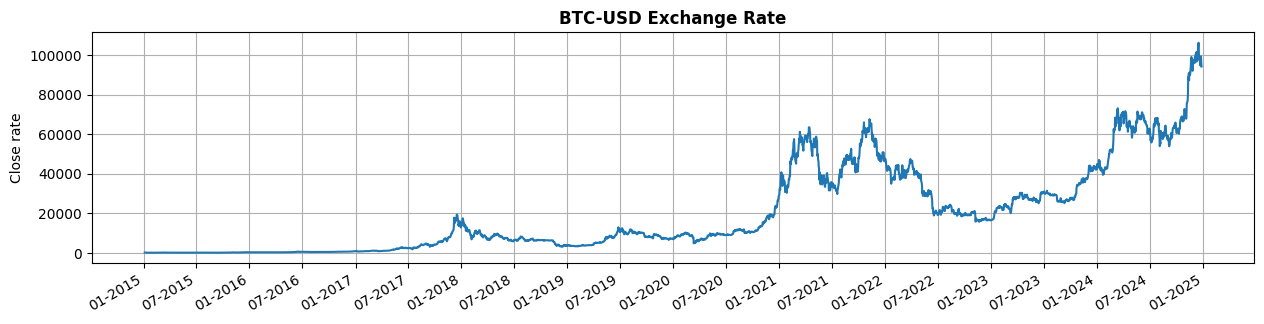

In [6]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot('date', 'Close', data=btc_usd_data)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.grid(True)
plt.ylabel('Close rate')
plt.title('BTC-USD Exchange Rate', fontweight='bold')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.show()

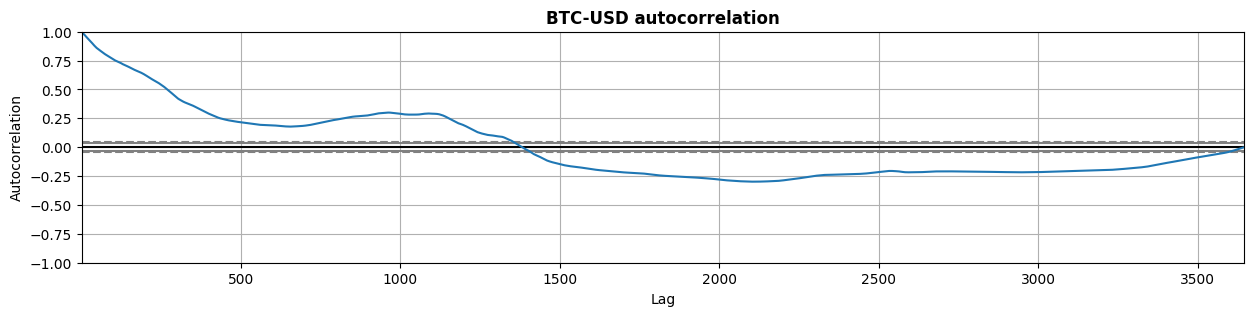

In [7]:
# autocorr = sm.tsa.acf(btc_usd_data['Close'], nlags=btc_usd_data.shape[0]-1)

plt.subplots(figsize=(15, 3))
pd.plotting.autocorrelation_plot(btc_usd_data['Close'])  
plt.title('BTC-USD autocorrelation', fontweight='bold')
plt.show()

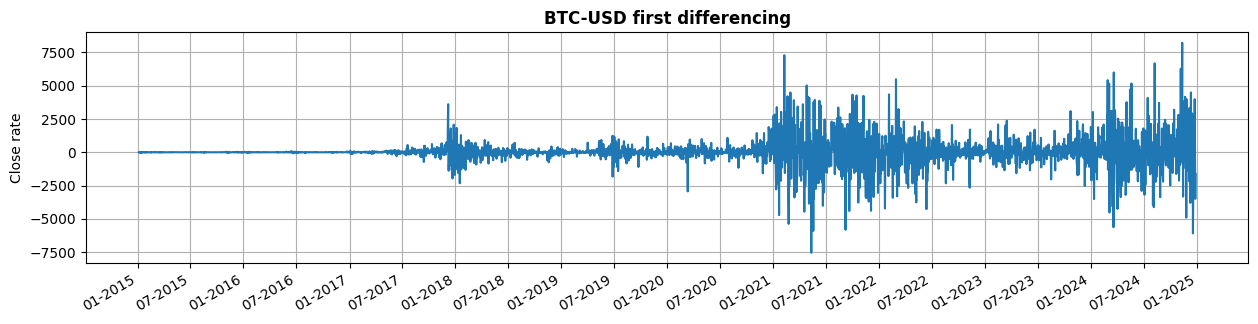

In [8]:
# First differencing
btc_usd_data['Close_1diff'] = pd.Series.diff(btc_usd_data['Close'])
btc_usd_data['Close_1diff'].fillna(0, inplace=True)

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot('date', 'Close_1diff', data=btc_usd_data)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.grid(True)
plt.ylabel('Close rate')
plt.title('BTC-USD first differencing', fontweight='bold')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.show()

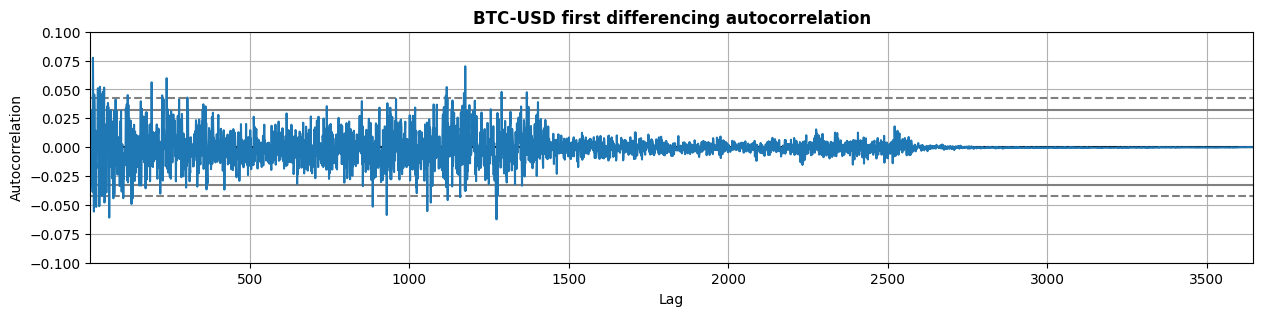

In [9]:
# autocorr = sm.tsa.acf(btc_usd_data['Close_1diff'], nlags=btc_usd_data.shape[0]-1)

plt.subplots(figsize=(15, 3))
pd.plotting.autocorrelation_plot(btc_usd_data['Close_1diff'])  
plt.title('BTC-USD first differencing autocorrelation', fontweight='bold')
plt.ylim([-0.1, 0.1])
plt.show()

In [10]:
btc_usd_data['ma7'] = btc_usd_data['Close'].rolling(7).mean()
btc_usd_data['ma30'] = btc_usd_data['Close'].rolling(30).mean()
btc_usd_data['ma90'] = btc_usd_data['Close'].rolling(90).mean()
btc_usd_data

,index,currency,date,Close,High,Low,Open,Volume,Close_1diff,ma7,ma30,ma90
0,5206,BTC-USD,2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800,0.000000,NaN,NaN,NaN
1,5207,BTC-USD,2015-01-06,286.188995,287.553009,272.696014,274.610992,23245700,11.714996,NaN,NaN,NaN
2,5208,BTC-USD,2015-01-07,294.337006,298.753998,283.079010,286.076996,24866800,8.148010,NaN,NaN,NaN
3,5209,BTC-USD,2015-01-08,283.348999,294.135010,282.174988,294.135010,19982500,-10.988007,NaN,NaN,NaN
4,5210,BTC-USD,2015-01-09,290.407990,291.114014,280.532990,282.382996,18718600,7.058990,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
3640,8846,BTC-USD,2024-12-23,94686.242188,96416.210938,92403.132812,95099.390625,65239002919,-418.695312,98349.275670,98371.539583,81127.809852
3641,8847,BTC-USD,2024-12-24,98676.093750,99404.062500,93448.015625,94684.343750,47114953674,3989.851562,97282.917411,98393.615365,81522.620399
3642,8848,BTC-USD,2024-12-25,99299.195312,99478.750000,97593.468750,98675.914062,33700394629,623.101562,97176.868304,98600.178646,81901.711241
3643,8849,BTC-USD,2024-12-26,95795.515625,99884.570312,95137.882812,99297.695312,47054980873,-3503.679688,96934.662946,98727.185156,82235.098481


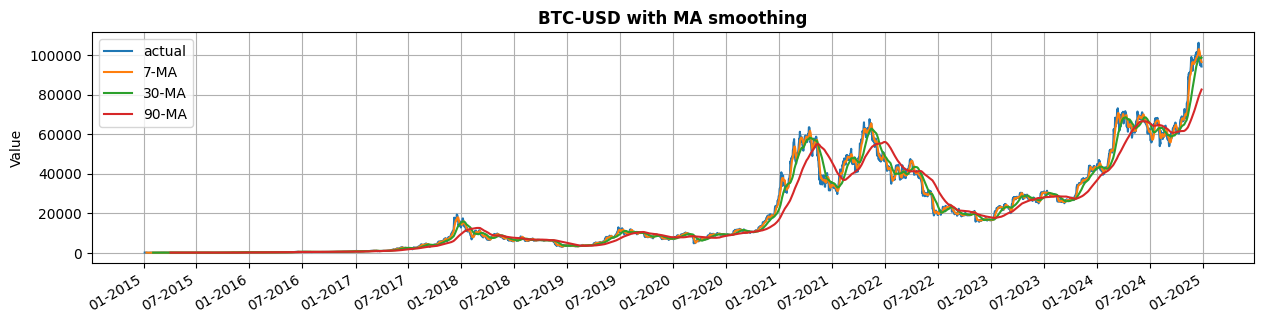

In [11]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot('date', 'Close', data=btc_usd_data, label='actual')
ax.plot('date', 'ma7', data=btc_usd_data, label='7-MA')
ax.plot('date', 'ma30', data=btc_usd_data, label='30-MA')
ax.plot('date', 'ma90', data=btc_usd_data, label='90-MA')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.grid(True)
plt.ylabel('Value')
plt.title('BTC-USD with MA smoothing', fontweight='bold')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
plt.legend()
plt.show()

# Classical Decomposition

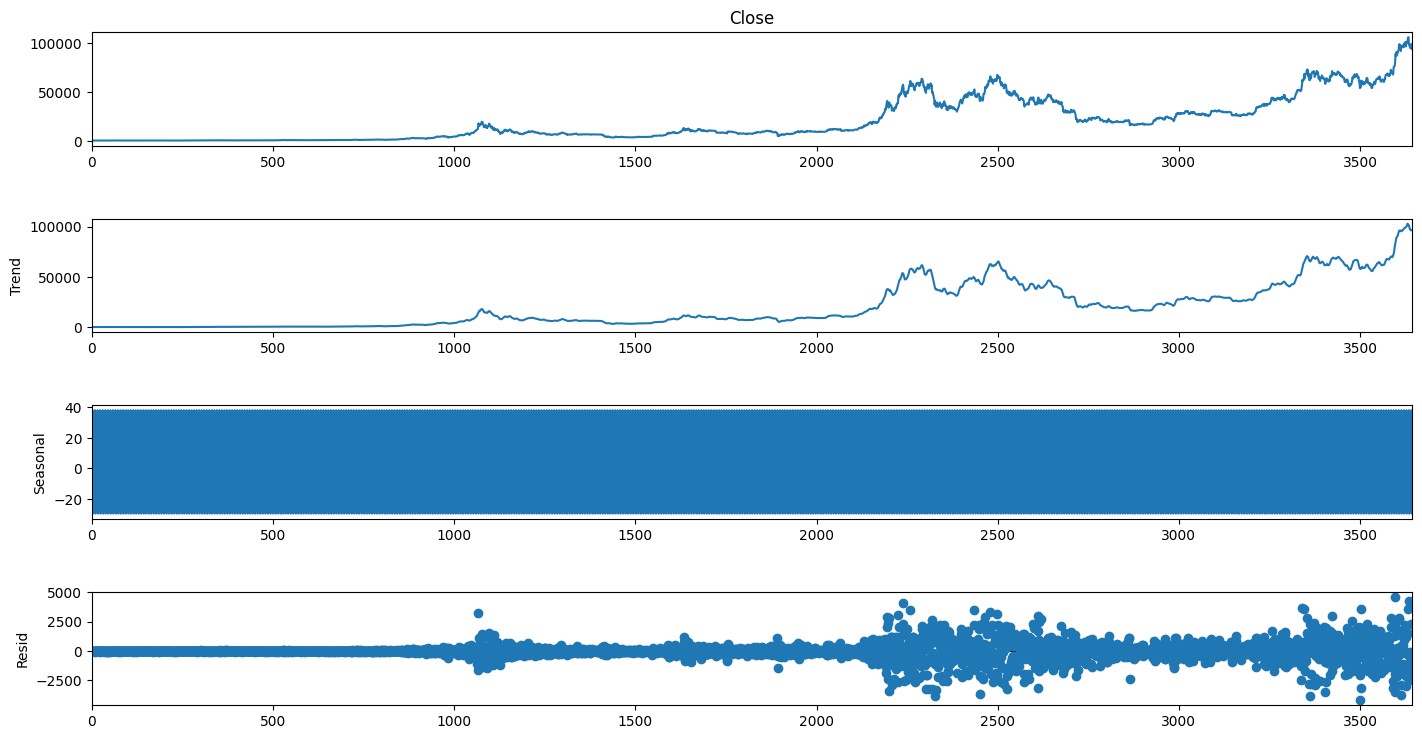

In [12]:
components = seasonal_decompose(btc_usd_data['Close'], period=7)
fig = components.plot()
fig.set_size_inches(16, 8)

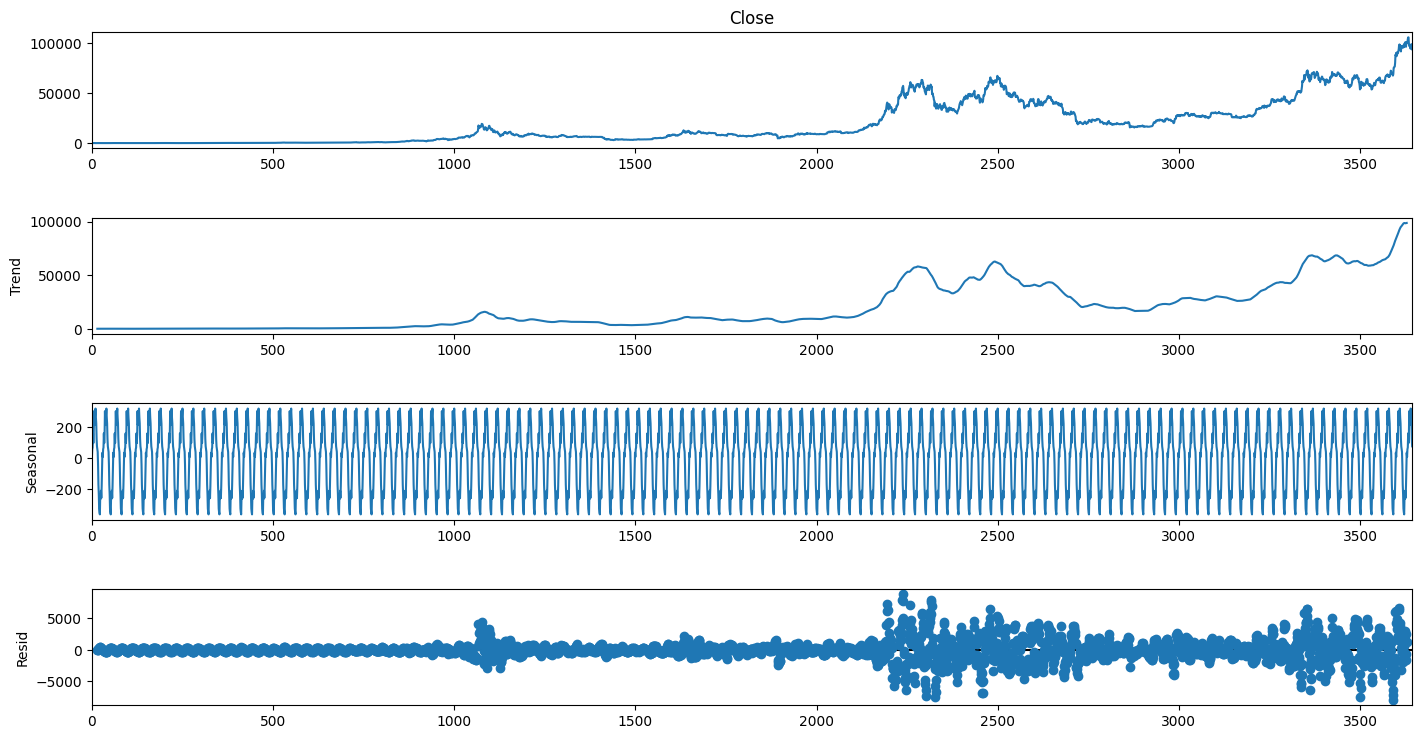

In [13]:
components = seasonal_decompose(btc_usd_data['Close'], period=30)
fig = components.plot()
fig.set_size_inches(16, 8)

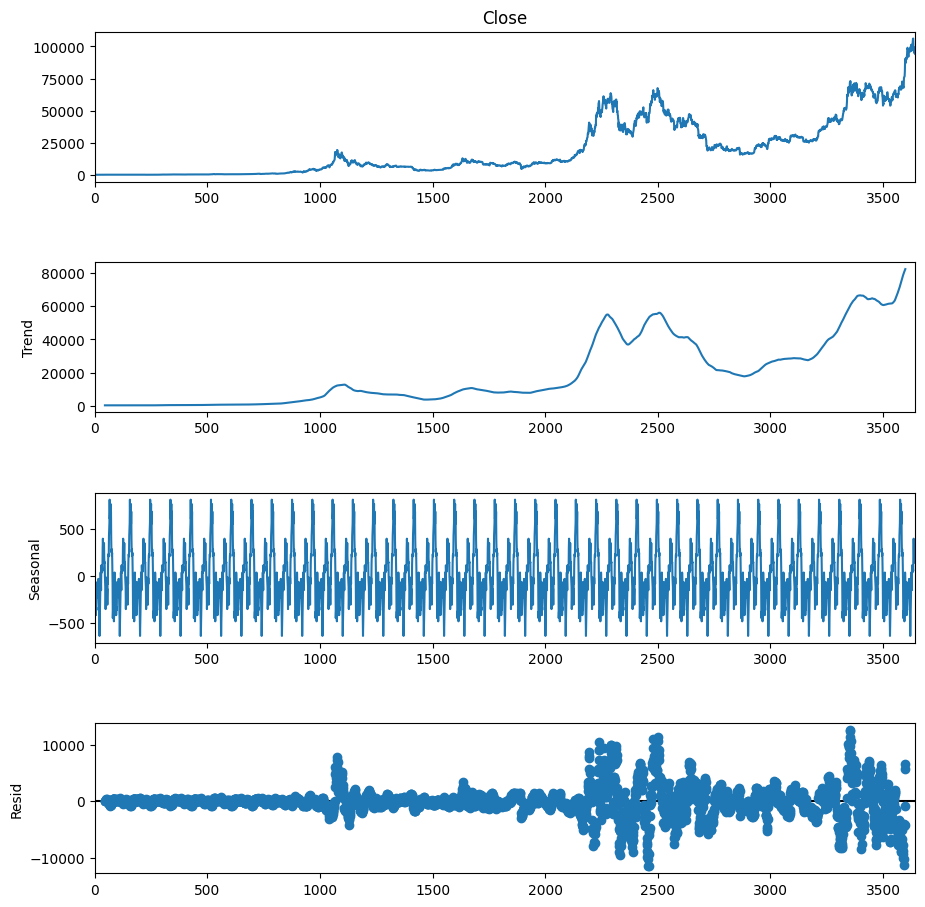

In [14]:
components = seasonal_decompose(btc_usd_data['Close'], period=90)
fig = components.plot()
fig.set_size_inches(10, 10)

# Train-Test Split

In [15]:
n_samples = len(btc_usd_data)
btc_usd_train = btc_usd_data.iloc[0:int(n_samples*0.8)]
btc_usd_test= btc_usd_data.iloc[int(n_samples*0.8):]

In [16]:
btc_usd_data.iloc[int(n_samples*0.8)]

index                         8122
currency                   BTC-USD
date           2022-12-30 00:00:00
Close                 16602.585938
High                  16643.427734
Low                   16408.474609
Open                  16641.330078
Volume                 15929162910
Close_1diff             -39.755859
ma7                   16732.031529
ma30                  16963.012565
ma90                  18075.211176
Name: 2916, dtype: object

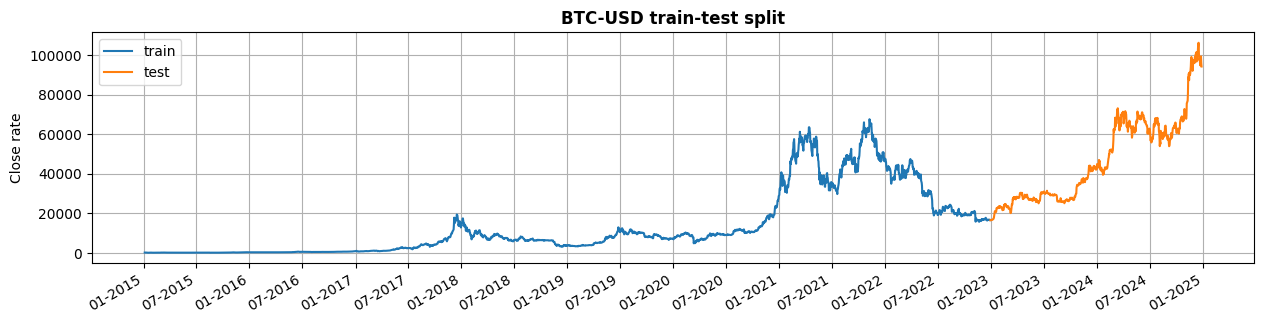

In [17]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot('date', 'Close', data=btc_usd_train, label='train')
ax.plot('date', 'Close', data=btc_usd_test, label='test')
plt.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.grid(True)
plt.ylabel('Close rate')
plt.title('BTC-USD train-test split', fontweight='bold')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

plt.show()

# Box-Cox transformation

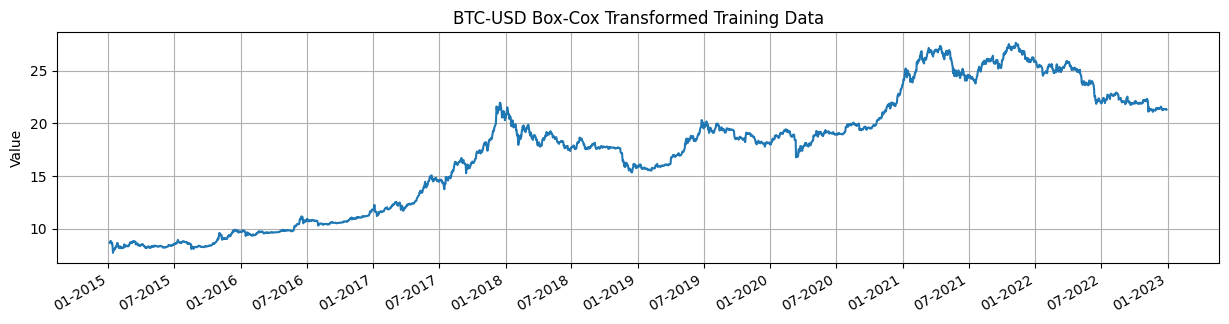

In [18]:
# # Apply box-cox transformation to the data
btc_usd_train['Close_boxcox'], lambda_optimal = stats.boxcox(btc_usd_train['Close'])

fig, ax = plt.subplots(figsize=(15, 3))
ax.plot('date', 'Close_boxcox', data=btc_usd_train, label='train')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
plt.grid(True)
plt.ylabel('Value')
plt.title('BTC-USD Box-Cox Transformed Training Data')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

plt.show()

In [19]:
#return the inverse of the transformation
def inverse_bocxcx(predictions, lambda_optimal):
    predictions = inv_boxcox(predictions, lambda_optimal)
    
    return predictions

# Benchmark Models

In [20]:
# Mean mthod
mean_pred = btc_usd_train['Close_boxcox'].mean()
btc_usd_test['Close_mean'] = inv_boxcox(mean_pred, lambda_optimal)

# Naive method
naive_pred = btc_usd_train['Close_boxcox'].iloc[-1]
btc_usd_test['Close_naive'] = inv_boxcox(naive_pred, lambda_optimal)

# Seasonal naive method
period = 90
last_season_values = btc_usd_train['Close_boxcox'].iloc[-period:]
ss_naive_pred = last_season_values.values.repeat(len(btc_usd_test)//period + 1)[:len(btc_usd_test)]
btc_usd_test['Close_ss_naive'] = inv_boxcox(ss_naive_pred, lambda_optimal)

# Drift method
first_value = btc_usd_train['Close_boxcox'].iloc[0]
last_value = btc_usd_train['Close_boxcox'].iloc[-1]
slope = (last_value-first_value) / (len(btc_usd_train)-1)

drift_pred = btc_usd_train['Close_boxcox'].iloc[-1] + slope*range(1, len(btc_usd_test)+1)
btc_usd_test['Close_drift'] = inv_boxcox(drift_pred, lambda_optimal)

btc_usd_test


,index,currency,date,Close,High,Low,Open,Volume,Close_1diff,ma7,ma30,ma90,Close_mean,Close_naive,Close_ss_naive,Close_drift
2916,8122,BTC-USD,2022-12-30,16602.585938,16643.427734,16408.474609,16641.330078,15929162910,-39.755859,16732.031529,16963.012565,18075.211176,5837.558297,16642.341797,19312.095703,16660.019530
2917,8123,BTC-USD,2022-12-31,16547.496094,16628.986328,16517.519531,16603.673828,11239186456,-55.089844,16689.137277,16949.024674,18047.471050,5837.558297,16642.341797,19312.095703,16677.713321
2918,8124,BTC-USD,2023-01-01,16625.080078,16630.439453,16521.234375,16547.914062,9244361700,77.583984,16658.150670,16933.572005,18014.154384,5837.558297,16642.341797,19312.095703,16695.423181
2919,8125,BTC-USD,2023-01-02,16688.470703,16759.343750,16572.228516,16625.509766,12097775227,63.390625,16625.102958,16926.246484,17973.616905,5837.558297,16642.341797,19312.095703,16713.149122
2920,8126,BTC-USD,2023-01-03,16679.857422,16760.447266,16622.371094,16688.847656,13903079207,-8.613281,16619.772042,16911.225521,17934.940690,5837.558297,16642.341797,19312.095703,16730.891157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3640,8846,BTC-USD,2024-12-23,94686.242188,96416.210938,92403.132812,95099.390625,65239002919,-418.695312,98349.275670,98371.539583,81127.809852,5837.558297,16642.341797,16906.304688,34527.852456
3641,8847,BTC-USD,2024-12-24,98676.093750,99404.062500,93448.015625,94684.343750,47114953674,3989.851562,97282.917411,98393.615365,81522.620399,5837.558297,16642.341797,16906.304688,34560.850390
3642,8848,BTC-USD,2024-12-25,99299.195312,99478.750000,97593.468750,98675.914062,33700394629,623.101562,97176.868304,98600.178646,81901.711241,5837.558297,16642.341797,16906.304688,34593.875292
3643,8849,BTC-USD,2024-12-26,95795.515625,99884.570312,95137.882812,99297.695312,47054980873,-3503.679688,96934.662946,98727.185156,82235.098481,5837.558297,16642.341797,16906.304688,34626.927180


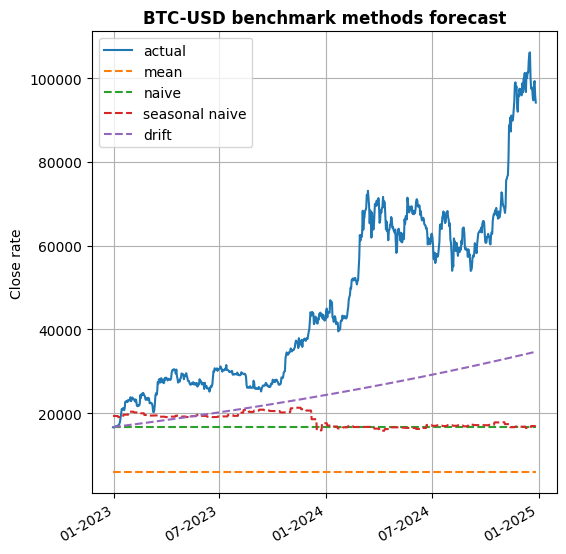

In [21]:
fig, ax = plt.subplots(figsize=(6, 6))
# ax.plot('date', 'Close', data=btc_usd_train, label='train')
ax.plot('date', 'Close', data=btc_usd_test, label='actual')
ax.plot('date', 'Close_mean', data=btc_usd_test, linestyle='--', label='mean')
ax.plot('date', 'Close_naive', data=btc_usd_test, linestyle='--', label='naive')
ax.plot('date', 'Close_ss_naive', data=btc_usd_test, linestyle='--', label='seasonal naive')
ax.plot('date', 'Close_drift', data=btc_usd_test, linestyle='--', label='drift')
plt.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.grid(True)
plt.ylabel('Close rate')
plt.title('BTC-USD benchmark methods forecast', fontweight='bold')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

plt.show()

In [24]:
def calculate_metrics(df, actual_col, benchmark_cols):
    """
    Calculate statistical metrics for each benchmark column against the actual column.

    :param df: DataFrame with actual and predicted data.
    :param actual_col: Column name of the actual values.
    :param benchmark_cols: List of column names for benchmark (predicted) values.
    :return: DataFrame with calculated metrics for each benchmark column.
    """
    metrics = pd.DataFrame(index=['MAE', 'MSE', 'RMSE', 'MAPE', 'R2'])

    for col in benchmark_cols:
        actual = df[actual_col]
        predicted = df[col]

        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        rmse = np.sqrt(mse)
        mape = np.mean(np.abs((actual - predicted) / actual)) * 100
        r2 = r2_score(actual, predicted)

        metrics[col] = [np.round(mae, 2), mse, rmse, mape, r2]

    return metrics

In [25]:
benchmark_metrics = calculate_metrics(btc_usd_test, actual_col='Close', benchmark_cols=benchmark_cols)
benchmark_metrics

,Close_mean,Close_naive,Close_ss_naive,Close_drift
MAE,4.126114e+04,3.045677e+04,2.892705e+04,2.236966e+04
MSE,2.163690e+09,1.388798e+09,1.350119e+09,7.815060e+08
RMSE,4.651548e+04,3.726658e+04,3.674397e+04,2.795543e+04
MAPE,8.474704e+01,5.651774e+01,5.130513e+01,4.093590e+01
R2,-3.691346e+00,-2.011214e+00,-1.927350e+00,-6.944733e-01


# ARIMA

In [26]:
arima_params = [(p, d, q) for p in [0, 1] for d in [0, 1, 2] for q in [0, 1, 2]]
df_train_copy = btc_usd_train.copy()

for p, d, q in arima_params:
    arima_model = ARIMA(df_train_copy['Close_boxcox'], order=(p, d, q)).fit()
    print(p, d, q, 'aicc', int(arima_model.aicc))
    start_point = max((p, d, q))
    preds = arima_model.forecast(steps=len(btc_usd_test))
    preds = inv_boxcox(preds, lambda_optimal)
    reindex_preds = pd.Series(preds.values, index=btc_usd_test.index)
    btc_usd_test[f'Close_arima_{(p, d, q)}']  = reindex_preds

0 0 0 aicc 18434
0 0 1 aicc 14502
0 0 2 aicc 11060
0 1 0 aicc -3061
0 1 1 aicc -3061
0 1 2 aicc -3060
0 2 0 aicc -975
0 2 1 aicc -3053
0 2 2 aicc -3052
1 0 0 aicc -3050
1 0 1 aicc -3049
1 0 2 aicc -3049
1 1 0 aicc -3061
1 1 1 aicc -3059
1 1 2 aicc -3063
1 2 0 aicc -1895
1 2 1 aicc -3052
1 2 2 aicc -3051


In [27]:
btc_usd_test

,index,currency,date,Close,High,Low,Open,Volume,Close_1diff,ma7,...,"Close_arima_(0, 2, 2)","Close_arima_(1, 0, 0)","Close_arima_(1, 0, 1)","Close_arima_(1, 0, 2)","Close_arima_(1, 1, 0)","Close_arima_(1, 1, 1)","Close_arima_(1, 1, 2)","Close_arima_(1, 2, 0)","Close_arima_(1, 2, 1)","Close_arima_(1, 2, 2)"
2916,8122,BTC-USD,2022-12-30,16602.585938,16643.427734,16408.474609,16641.330078,15929162910,-39.755859,16732.031529,...,16608.204569,16632.197795,16630.682007,16626.642655,16640.329966,16640.174317,16630.620154,16599.718345,16607.955343,16608.732007
2917,8123,BTC-USD,2022-12-31,16547.496094,16628.986328,16517.519531,16603.673828,11239186456,-55.089844,16689.137277,...,16577.111583,16622.065440,16620.991518,16618.658458,16640.374949,16641.425632,16622.137316,16626.106271,16576.888648,16580.389952
2918,8124,BTC-USD,2023-01-01,16625.080078,16630.439453,16521.234375,16547.914062,9244361700,77.583984,16658.150670,...,16546.068396,16611.944714,16611.311669,16608.538037,16640.373943,16640.703204,16613.821851,16616.550243,16545.786122,16549.793922
2919,8125,BTC-USD,2023-01-02,16688.470703,16759.343750,16572.228516,16625.509766,12097775227,63.390625,16625.102958,...,16515.074941,16601.835602,16601.642444,16598.429231,16640.373966,16641.120278,16605.670387,16625.723838,16514.735765,16520.257281
2920,8126,BTC-USD,2023-01-03,16679.857422,16760.447266,16622.371094,16688.847656,13903079207,-8.613281,16619.772042,...,16484.131152,16591.738087,16591.983831,16588.332026,16640.373965,16640.879489,16597.679625,16625.140805,16483.735199,16490.320313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3640,8846,BTC-USD,2024-12-23,94686.242188,96416.210938,92403.132812,95099.390625,65239002919,-418.695312,98349.275670,...,3668.297492,11556.290359,11706.234653,11553.469328,16640.373965,16640.967621,16196.091461,18717.531641,3656.787842,3905.586781
3641,8847,BTC-USD,2024-12-24,98676.093750,99404.062500,93448.015625,94684.343750,47114953674,3989.851562,97282.917411,...,3659.753785,11551.578074,11701.586673,11548.758057,16640.373965,16640.967621,16196.091455,18720.585559,3648.251290,3896.907773
3642,8848,BTC-USD,2024-12-25,99299.195312,99478.750000,97593.468750,98675.914062,33700394629,623.101562,97176.868304,...,3651.227103,11546.870386,11696.943059,11544.051384,16640.373965,16640.967621,16196.091449,18723.639903,3639.731787,3888.245265
3643,8849,BTC-USD,2024-12-26,95795.515625,99884.570312,95137.882812,99297.695312,47054980873,-3503.679688,96934.662946,...,3642.717417,11542.167290,11692.303805,11539.349303,16640.373965,16640.967621,16196.091443,18726.694673,3631.229306,3879.599231


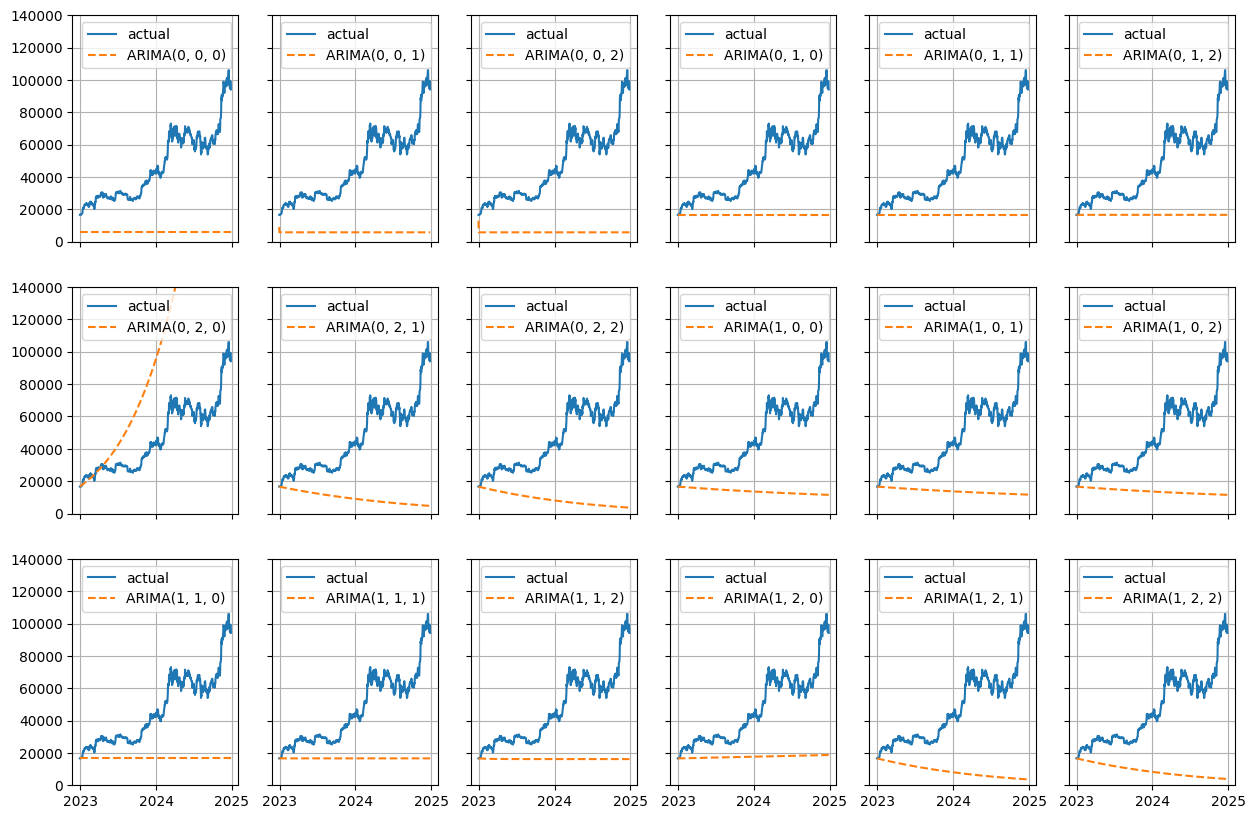

In [28]:
nr, nc = 3, 6
fig, axes = plt.subplots(nrows=nr, ncols=nc, sharex=True, sharey=True, figsize=(15, 10))
axes = axes.reshape(nr*nc)

for ax, params in zip(axes, arima_params):
    p, d, q = params[0], params[1], params[2]
    ax.plot('date', 'Close', data=btc_usd_test, label='actual')
    ax.plot('date', f'Close_arima_{(p, d, q)}', data=btc_usd_test, linestyle='--', label=f'ARIMA{(p, d, q)}')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 13)))
    ax.legend()
    ax.grid(True)
    ax.set_ylim([0, 140000])

plt.show()

In [29]:
arima_cols = [f'Close_arima_{(p, d, q)}' for p, d, q in arima_params]
arima_metrics = calculate_metrics(btc_usd_test, actual_col='Close', benchmark_cols=arima_cols)
arima_metrics

,"Close_arima_(0, 0, 0)","Close_arima_(0, 0, 1)","Close_arima_(0, 0, 2)","Close_arima_(0, 1, 0)","Close_arima_(0, 1, 1)","Close_arima_(0, 1, 2)","Close_arima_(0, 2, 0)","Close_arima_(0, 2, 1)","Close_arima_(0, 2, 2)","Close_arima_(1, 0, 0)","Close_arima_(1, 0, 1)","Close_arima_(1, 0, 2)","Close_arima_(1, 1, 0)","Close_arima_(1, 1, 1)","Close_arima_(1, 1, 2)","Close_arima_(1, 2, 0)","Close_arima_(1, 2, 1)","Close_arima_(1, 2, 2)"
MAE,4.126114e+04,4.125809e+04,4.125200e+04,3.045677e+04,3.045861e+04,3.046038e+04,8.089242e+04,3.748944e+04,3.832844e+04,3.333828e+04,3.324177e+04,3.334141e+04,3.045872e+04,3.045813e+04,3.087218e+04,2.944445e+04,3.833804e+04,3.813358e+04
MSE,2.163691e+09,2.163725e+09,2.163759e+09,1.388798e+09,1.388911e+09,1.389020e+09,1.306683e+10,2.009264e+09,2.084896e+09,1.631269e+09,1.623127e+09,1.631472e+09,1.388918e+09,1.388882e+09,1.415795e+09,1.304364e+09,2.085758e+09,2.067366e+09
RMSE,4.651549e+04,4.651586e+04,4.651623e+04,3.726658e+04,3.726810e+04,3.726956e+04,1.143102e+05,4.482482e+04,4.566067e+04,4.038898e+04,4.028805e+04,4.039148e+04,3.726819e+04,3.726771e+04,3.762705e+04,3.611599e+04,4.567010e+04,4.546830e+04
MAPE,8.474706e+01,8.472389e+01,8.468128e+01,5.651774e+01,5.652250e+01,5.652707e+01,1.366322e+02,7.112849e+01,7.299981e+01,6.244147e+01,6.223654e+01,6.244976e+01,5.652279e+01,5.652126e+01,5.754240e+01,5.453428e+01,7.302149e+01,7.256164e+01
R2,-3.691347e+00,-3.691421e+00,-3.691496e+00,-2.011214e+00,-2.011459e+00,-2.011695e+00,-2.733169e+01,-3.356518e+00,-3.520504e+00,-2.536943e+00,-2.519289e+00,-2.537382e+00,-2.011473e+00,-2.011395e+00,-2.069748e+00,-1.828143e+00,-3.522372e+00,-3.482495e+00


In [30]:
for p, d, q in arima_params:
    position = pd.Series(np.sign(btc_usd_test[f'Close_arima_{(p, d, q)}'] - btc_usd_test['Close'].shift(1)))
    btc_usd_test[f'daily_return_arima_{(p, d, q)}'] = position.shift(1) * btc_usd_test['daily_return']
    btc_usd_test[f'cum_return_arima_{(p, d, q)}'] = btc_usd_test[f'daily_return_arima_{(p, d, q)}'].cumsum().apply(np.exp)

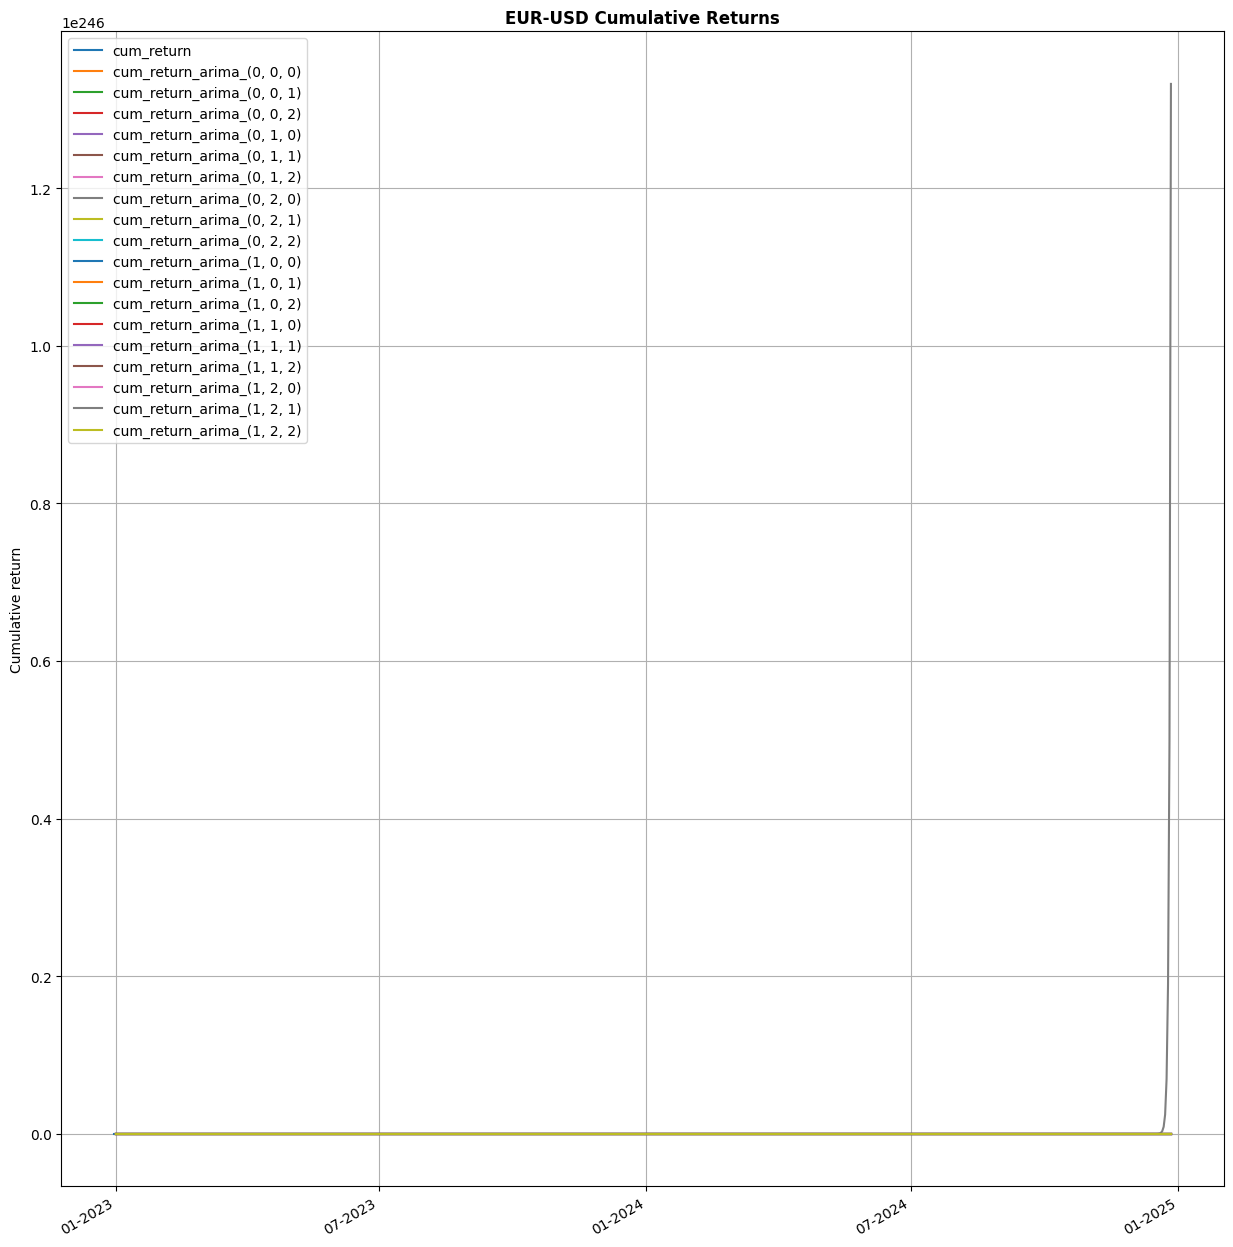

In [31]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.plot('date', 'cum_return', data=btc_usd_test, label='cum_return')

for p, d, q in arima_params:
    ax.plot('date', f'cum_return_arima_{(p, d, q)}', data=btc_usd_test, label=f'cum_return_arima_{(p, d, q)}')

plt.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.grid(True)
plt.ylabel('Cumulative return')
plt.title('EUR-USD Cumulative Returns', fontweight='bold')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

# GAM

In [32]:
df_train_copy = btc_usd_train.copy()
df_train_copy['date'] = pd.to_datetime(df_train_copy['date'])
df_train_copy['year'] = df_train_copy['date'].dt.year
df_train_copy['month'] = df_train_copy['date'].dt.month
df_train_copy['day'] = df_train_copy['date'].dt.day
df_train_copy['weekday'] = df_train_copy['date'].dt.weekday

n_days = 7
df_train_copy[f'lag_{n_days}'] = df_train_copy['Close'].shift(n_days)
df_train_copy = df_train_copy.dropna()

features = ['year', 'month', 'day', 'weekday', f'lag_{n_days}']
# features = ['year', 'month', 'day', 'weekday']
X = df_train_copy[features]
y = df_train_copy['Close']

gam_model = LinearGAM(s(1) + s(2) + s(3) + s(4)).fit(X, y)

In [33]:
df_test_copy = btc_usd_test.copy()
df_test_copy['date'] = pd.to_datetime(df_test_copy['date'])
df_test_copy['year'] = df_test_copy['date'].dt.year
df_test_copy['month'] = df_test_copy['date'].dt.month
df_test_copy['day'] = df_test_copy['date'].dt.day
df_test_copy['weekday'] = df_test_copy['date'].dt.weekday
# f_test_copy['Close_boxcox'], lambda_optimal_copy = stats.boxcox(df_test_copy['Close'])

n_days = 7
df_test_copy[f'lag_{n_days}'] = pd.concat((df_train_copy['Close'][-n_days:], df_test_copy['Close'])).shift(n_days)

X_test = df_test_copy[features]

preds = gam_model.predict(X_test)
# preds = inv_boxcox(preds, lambda_optimal_copy)
btc_usd_test['Close_gam'] = preds
# df_test_copy['Close_boxcox']
preds
# btc_usd_test['Close_gam']

array([17506.49964278, 17480.99804045, 16974.04619027, 17081.39010943,
       16864.79815237, 16656.06927962, 16721.74020509, 16735.90484949,
       16673.83499483, 16696.00202937, 16702.0910798 , 16620.77556396,
       16695.76557809, 16577.83613717, 16656.65319114, 16653.8497339 ,
       16770.34188176, 16809.65404929, 17008.23129426, 17510.98582783,
       18335.94633415, 19174.45085197, 20002.9475625 , 19744.15768708,
       20078.93736439, 20184.87486696, 19729.87212097, 20136.59377925,
       21992.03114289, 22339.98376958, 22516.97228469, 22843.77444851,
       22438.43585126, 23958.44176491, 23867.48305918, 23890.87119278,
       23773.84821888, 24661.29287582, 23619.39915734, 23963.03049251,
       24599.07898402, 24216.79805936, 24116.78070023, 23875.92285967,
       23370.45946587, 23125.46011872, 23711.44588356, 23321.41152167,
       21988.53713284, 21786.84607066, 22094.05425956, 22058.14394318,
       22005.75149474, 22263.62590964, 24542.94029608, 23725.12878822,
      

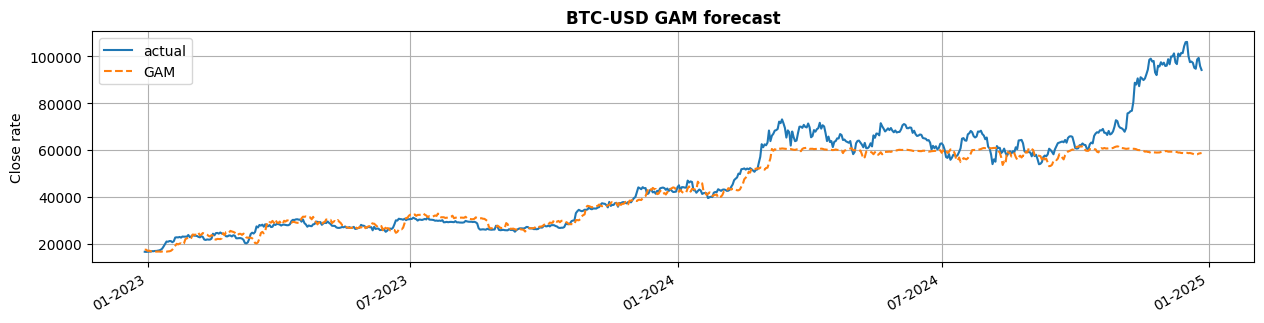

In [34]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot('date', 'Close', data=btc_usd_test, label='actual')
ax.plot('date', 'Close_gam', data=btc_usd_test, linestyle='--', label='GAM')
plt.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.grid(True)
plt.ylabel('Close rate')
plt.title('BTC-USD GAM forecast', fontweight='bold')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')
# plt.ylim([10000, 150000])

plt.show()

In [35]:
gam_metrics = calculate_metrics(btc_usd_test, actual_col='Close', benchmark_cols=['Close_gam'])
gam_metrics

,Close_gam
MAE,5.452390e+03
MSE,1.108957e+08
RMSE,1.053070e+04
MAPE,8.875758e+00
R2,7.595542e-01


# Neural Nets

In [36]:
from sklearn.preprocessing import MinMaxScaler
from keras import Sequential
from keras.layers import Dense, RNN, LSTM, GRU

2025-01-18 15:17:14.709691: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-18 15:17:14.788693: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-18 15:17:14.823967: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-18 15:17:14.834551: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-18 15:17:14.898921: I tensorflow/core/platform/cpu_feature_guar

In [63]:

window_size = 30
scaler = MinMaxScaler().fit(btc_usd_train[['Close']])
close_scaled_train = scaler.transform(btc_usd_train[['Close']])
close_scaled_test = scaler.transform(btc_usd_test[['Close']])
close_scaled_test = np.concatenate((close_scaled_train[-window_size:], close_scaled_test), axis=0)


def preprocess(series, window_size):
    sequences = []
    targets = []
    for i in range(len(series)-window_size):
        sequences.append(series[i:i+window_size])
        targets.append(series[i+window_size])
        
    X = np.array(sequences)
    y = np.array(targets)

    return X, y

def lstm_model():
    model = Sequential()
    model.add(LSTM(4, input_shape=(window_size, 1)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    return model

def gru_model():
    model = Sequential()
    model.add(GRU(4, input_shape=(window_size, 1)))
    model.add(Dense(1))
    model.compile(loss='mse', optimizer='adam')

    return model

In [68]:
X_train, y_train = preprocess(close_scaled_train, window_size)
X_test, y_test = preprocess(close_scaled_test, window_size)

lstm_model = lstm_model()
lstm_model.fit(X_train, y_train, epochs=5, batch_size=1) 

gru_model = gru_model()
gru_model.fit(X_train, y_train, epochs=5, batch_size=1) 


Epoch 1/5
2886/2886 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.0028
Epoch 2/5
2886/2886 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 5.3198e-04
Epoch 3/5
2886/2886 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 4.2409e-04
Epoch 4/5
2886/2886 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 3.1743e-04
Epoch 5/5
2886/2886 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 2.7934e-04
Epoch 1/5
2886/2886 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 0.0316
Epoch 2/5
2886/2886 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 3.9322e-04
Epoch 3/5
2886/2886 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - loss: 3.2096e-04
Epoch 4/5
2886/2886 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 2.3965e-04
Epoch 5/5
2886/2886 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - loss: 2.2649e-04


In [69]:
lstm_preds = lstm_model.predict(X_test)
btc_usd_test['Close_lstm'] = scaler.inverse_transform(lstm_preds)

gru_preds = lstm_model.predict(X_test)
btc_usd_test['Close_gru'] = scaler.inverse_transform(gru_preds)

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


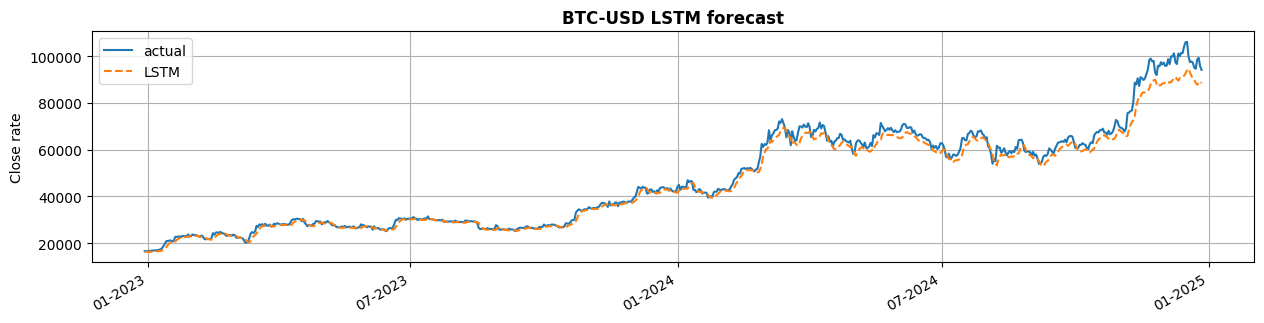

In [74]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot('date', 'Close', data=btc_usd_test, label='actual')
ax.plot('date', 'Close_lstm', data=btc_usd_test, linestyle='--', label='LSTM')
# ax.plot('date', 'Close_gru', data=btc_usd_test, linestyle='--', label='GRU')
plt.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.grid(True)
plt.ylabel('Close rate')
plt.title('BTC-USD LSTM forecast', fontweight='bold')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

plt.show()

In [75]:
nn_metrics = calculate_metrics(btc_usd_test, actual_col='Close', benchmark_cols=['Close_lstm', 'Close_gru'])
nn_metrics

,Close_lstm,Close_gru
MAE,1.950820e+03,1.950820e+03
MSE,9.342110e+06,9.342110e+06
RMSE,3.056486e+03,3.056486e+03
MAPE,3.453318e+00,3.453318e+00
R2,9.797443e-01,9.797443e-01


# Gradient Boosting

In [79]:
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit,GridSearchCV
import math

In [107]:
def gb_model(X_train, y_train):
    param_grid = {
    'objective': ['reg:squarederror'],
    'eval_metric': ['logloss'],
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'gamma':[0,0.1,0.3,0.5], 
    'max_depth': [5, 7, 8]
    }

    # len(Xtrain)/n_splits - gaps * n_splits - 1  
    testSize = math.floor(len(X_train) / 4) - 4 - 1

    #time series split for cross validation
    tss = TimeSeriesSplit(n_splits=4, test_size=testSize, gap=1)
    
    #create model and tune hyperparameters
    xgb_model = XGBRegressor()
    grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=tss, scoring='r2')
    grid_search.fit(X_train, y_train)

    return grid_search.best_estimator_

In [108]:
df_train_copy = btc_usd_train.copy()
df_train_copy['date'] = pd.to_datetime(df_train_copy['date'])
df_train_copy['year'] = df_train_copy['date'].dt.year
df_train_copy['month'] = df_train_copy['date'].dt.month
df_train_copy['day'] = df_train_copy['date'].dt.day
df_train_copy['weekday'] = df_train_copy['date'].dt.weekday

features = ['year','month','day', 'weekday']
X_train = df_train_copy[features]
y_train = df_train_copy['Close'] 

df_test_copy = btc_usd_test.copy()
df_test_copy['date'] = pd.to_datetime(df_test_copy['date'])
df_test_copy['year'] = df_test_copy['date'].dt.year
df_test_copy['month'] = df_test_copy['date'].dt.month
df_test_copy['day'] = df_test_copy['date'].dt.day
df_test_copy['weekday'] = df_test_copy['date'].dt.weekday

X_test = df_test_copy[features]
y_test = df_test_copy['Close']

gb = gb_model(X_train, y_train)

In [113]:
btc_usd_test['Close_gb'] = gb.predict(X_test)
btc_usd_test['Close_gb']

2916    16947.591797
2917    16815.259766
2918    47785.449219
2919    45167.421875
2920    46149.777344
            ...     
3640    16837.039062
3641    17289.056641
3642    17225.566406
3643    17025.453125
3644    16549.468750
Name: Close_gb, Length: 729, dtype: float32

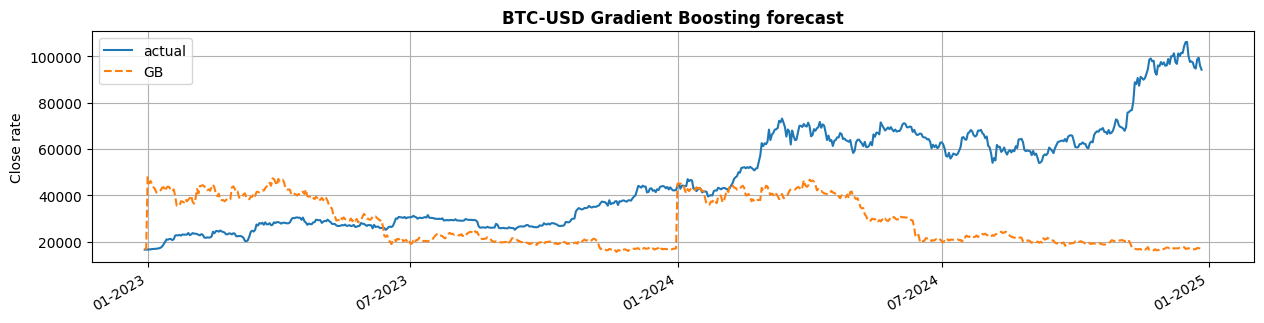

In [111]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot('date', 'Close', data=btc_usd_test, label='actual')
ax.plot('date', 'Close_gb', data=btc_usd_test, linestyle='--', label='GB')
plt.legend()
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%Y'))
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=(1, 7)))
ax.grid(True)
plt.ylabel('Close rate')
plt.title('BTC-USD Gradient Boosting forecast', fontweight='bold')
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=30, horizontalalignment='right')

plt.show()

In [112]:
gb_metrics = calculate_metrics(btc_usd_test, actual_col='Close', benchmark_cols=['Close_gb'])
gb_metrics

,Close_gb
MAE,2.490164e+04
MSE,1.027918e+09
RMSE,3.206115e+04
MAPE,4.916126e+01
R2,-1.228747e+00
